63f78014766fd30436c18a79_Hyperspace - navbar logo.png


# Building a RAG system using Hyperspace
Retrieval-Augmented Generation (RAG) is a method to improve the quality and accuracy of generated responses by combining retrieval-based methods with generative models. RAG methods produce more informed and contextually relevantresults by feeding the genrative model with external knowledge sources during the generation process, RAG can produce more informed, contextually relevant, and factually accurate outputs compared to traditional generative models.


This notebook illustrates the application of Hyperspace hybrid search to create simple RAG that improves the output of a chat LLM.

As the LLM, we will use the Microsoft  [DialoGPT-small](https://huggingface.co/microsoft/DialoGPT-small)! model from the Hugging face website 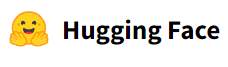
The vectors were embedded using the [all-MiniLM-L6-v2 model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/ImageAndTextSearch/ImageAndTextSearch.ipynb)

# The Dataset - Hyperspace Documentation
The chat will allow search in Hyperspace documentation. We will first use BeautifulSoup4 to collect information from the Hyperspace website, and use it to improve the chat requests.
We will use Hyperspace filtering in order to prevent the system from returning results to irrelevant queries.

# Installing Relevant Packages
We start by installing required packages

In [307]:
!pip install InstructorEmbedding
!pip install sentence-transformers==2.2.2
!pip install beautifulsoup4 requests
!pip install sentence-transformers
!pip install transformers
!pip install torch

# Collecting the Data
We use the BeautifulSoup package to scan the Hyperspace documentation and create a corresponding data collection. We then parse the documentation into individual sections, each stored as a separate document, and use Hyperspace Hybrid search for retrieval.

In [385]:
import requests
from bs4 import BeautifulSoup
import os
import regex as re

folder_name = 'docs' # local folder to store the documentation
os.makedirs(folder_name, exist_ok=True)
documents = []

known_words = ["keyword","return", "True","list","fieldname","function",
              "between", "vector","parameter","score","should","must","clause",
               "aggregate","configuration","section","boost","commit","string",
               "False","aggregation","candidate","filter"]
replacements = {"themin": "the min", "typekeywordorlist": "type keyword or list",
                "Hyperspaces": "Hyperspace", "uploading": "upload", "combining": "combine",
                "filtering": "filter", "commiting": "commit", "scoring": "score",
                "indexing": "index", "matching": "match", "debugging": "debug"}
def normalize_text(text):
  text = text.lower()
  for i in range(0):
    text = text.replace(str(i), " ")
  for char in [")","_","(","-"]:
    text = text.replace(char, " ")
  for word in known_words:
    text = text.replace(word + "s", " " + word + "s ")
    text = text.replace(word, " " + word + " ")
  text = text.replace("'","")
  text = text.replace(")"," ")
  text = text.replace("("," ")
  for key in replacements.keys():
    text = text.replace(key, replacements[key])
  text = text.replace("  ", " ")

  return text

def split_text(text):
    parts = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    return [part.strip() for part in parts if part]

def unique_elements(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]

# Hyperspace documentation url
base_url = 'https://docs.hyper-space.io/hyperspace-docs'

response = requests.get(base_url)
response.raise_for_status()

soup = BeautifulSoup(response.content, 'html.parser')

urls = unique_elements([link for link in soup.find_all('a', href=True) if "hyperspace-docs" in link['href']])[1:]


In [386]:
for address in urls:
    base_url = 'https://docs.hyper-space.io' + address['href']
    try:
      response = requests.get(base_url)
    except:
      print("Error: Failed to retrieve ", base_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'lxml')
        main_content = soup.find('main', class_='flex-1')

        if main_content:
            content = main_content.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p'])
            current_header = None
            file = None
            doc = {"Sentences": [], "url": base_url}
            for element in content:
                if element.name in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
                    if file:
                        file.close()
                    current_header = element.get_text(strip=True).replace('/', '-')
                    if "header" in doc.keys() and len(doc["Sentences"])  > 0:
                        documents.append(doc)
                        doc = {"Sentences": [], "url": base_url}
                    doc["header"] = normalize_text(current_header)
                    file_path = os.path.join(folder_name, f"{current_header}.txt")
                    file = open(file_path, 'w', encoding='utf-8')

                elif element.name == 'p' and current_header:
                    if file:
                        text = element.get_text(strip=True)

                        if len(text) < 5:
                            continue
                        doc["full_text"] = normalize_text(text)
                        for sentence in split_text(doc["full_text"]):
                            if len(sentence) < 5:
                                continue
                            sentence = " ".join([word for word in sentence.split(" ") if len(word) > 1])
                            if len(sentence.split(" ")) < 3:
                              continue
                            doc["Sentences"].append(sentence)
                            file.write(sentence + '\n')

            if file:
                file.close()
        else:
            print("No main content section found. Please check your HTML structure.")
    else:
        print(f"Failed to retrieve {base_url}: Status code {response.status_code}")



Error: Failed to retrieve  https://docs.hyper-space.iohttps://docs.hyper-space.io/hyperspace-docs/flows/data-collections/supported-data-types
Error: Failed to retrieve  https://docs.hyper-space.iohttps://docs.hyper-space.io/hyperspace-docs/flows/data-collections/supported-data-types


Let us examine the collected data

In [387]:
documents

[{'Sentences': ['hyperspace is cloud search database that leverages cloud hardware to enhance search speed and relevancy.',
   'hyperspace uses search processing unit spu virtual chip—a domain specific architecture optimized for search tasks, to provide unmatched performance for real time applications at scale, maintaining cost efficiency without compromising over logic complexity.',
   'hyperspace is managed saas solution, combine hardware level speed with software level flexibility and designed to support wide range of ai applications such as real time recommendations, fraud prevention, ad tech, rag, and threat detection.'],
  'url': 'https://docs.hyper-space.io/hyperspace-docs',
  'header': 'overview',
  'full_text': 'hyperspace is a managed saas solution, combine hardware level speed with software level flexibility and designed to support a wide range of ai applications such as real time recommendations, fraud prevention, ad tech, rag, and threat detection.'},
 {'Sentences': ['hype

In the next step, we will use NLTK to parse the data. Note that Hyperspace supports free text search and this can be done withing Hyperspace as well.

In [329]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words= set(list(stopwords.words('english')) + ["I", "The","a","an", '..'])

def get_wordnet_pos(word, tag):
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    return tag_dict.get(tag[0].upper(), wordnet.NOUN)

def lemmetize_text(text):
  tokens = nltk.word_tokenize(text)
  lemmatizer = WordNetLemmatizer()
  tagged = nltk.pos_tag(nltk.word_tokenize(text))
  return [lemmatizer.lemmatize(word, get_wordnet_pos(word, tag)) for word, tag in tagged if word not in stop_words and (len(word) > 1 or word.isdigit()) and word != "``"]



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Finally, we embbed the text of each document using the all-MiniLM-L6-v2 model.

In [388]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

data = []
for i, document in enumerate(documents):
  for sentence in document["Sentences"]:
    new_doc = {key: document[key] for key in document.keys() if key!= "Sentences"}
    new_doc["embedded_sentence"] = list([float(x) for x in embedding_model.encode(sentence)])
    new_doc["parent_id"] = str(i)
    new_doc["full_text"] = document["full_text"]
    new_doc["keywords"] = lemmetize_text(sentence)
    new_doc["header keywords"] = lemmetize_text(new_doc["header"])
    data.append(new_doc)

In [405]:
data[0]["header keywords"]

['overview']

# Setting up the Hyperspace environment
We are now moving to Ingesting and Querying the data. Working with Hyperspace requires the following steps:

1. Install the client API
2. Create data config file
3. Connect to a server
4. Create collection
5. Ingest data
6. Run query

## 1. Install the client API
Hyperspace API can be installed directly from git, using the following command

In [315]:
pip install git+https://github.com/hyper-space-io/hyperspace-py

  Cloning https://github.com/hyper-space-io/hyperspace-py to /tmp/pip-req-build-tbcdr0eg
  Running command git clone --filter=blob:none --quiet https://github.com/hyper-space-io/hyperspace-py /tmp/pip-req-build-tbcdr0eg
  Resolved https://github.com/hyper-space-io/hyperspace-py to commit 749fd8016074f537e9bcb2674e3d9aef35e71e5d
  Preparing metadata (setup.py) ... done


#2. Connect to a server

Once the Hyperspace API is installed, the database can be accessed by creating a local instance of the Hyperspace client. This step requires host address, username and password

In [389]:
import hyperspace

host = 'host'
username = "username"
password = "password"

hyperspace_client = hyperspace.HyperspaceClientApi(username=username, password=password, host=host)

#3.   Create a Data Schema File

Similarly to other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Here, we create a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" (inner product) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.
Here, we use "brute_force" (exact KNN) with inner product.

In [436]:
import json

config = {
    "configuration": {
        "id": {
            "type": "keyword",
            "id": True
        },
        "parent_id": {
            "type": "keyword",
        },
        "url": {
            "type": "keyword"
        },

        "header": {
            "type": "keyword"
        },
        "keywords": {
            "type": "keyword"
        },
        "text": {
            "type": "keyword"
        },
        "header keywords": {
            "type": "keyword"
        },

        "embedded_sentence": {
            "type": "dense_vector",
            "dim": 384,
            "index_type": "brute_force",
        }
    }
}



## 4. Create Collection
Hyperspace stores data in Collections, where each collections, that are sub repositories in the cloud. Each search then operates within a specific collection. To create a collection, use the command **"create_collection(schema_filename, collection_name)"**.







In [437]:
collection_name = 'Hyperspace_RAG'
if collection_name in hyperspace_client.collections_info()["collections"]:
  hyperspace_client.delete_collection(collection_name)
hyperspace_client.create_collection(config, collection_name)
hyperspace_client.collections_info()

{'collections': {'Hyperspace_RAG': {'creation_time': '2024-07-07T14:34:32Z',
   'size': 0}}}

## 5. Ingest data

We ingest the dataset to the Hyperspace database in batches of 500 documents. The batch size can be controlled by user, and in particular, can be increased in order decrease ingestion time. You can batches of data using the command **add_batch(batch, collection_name)**.
If no Id per document is provided, Hyperspace will randomly assign one.

Here, we will assign id values to each documents by adding an "id" field to the data. If the id field is decalred in the data schema config file, this step is mandatory.

In [438]:
import math

BATCH_SIZE = 500

batch = []
for i, doc in enumerate(data):
    doc['id'] = str(i)
    batch.append(doc)

    if i % BATCH_SIZE == 0:
        response = hyperspace_client.add_batch(batch, collection_name)
        batch.clear()
        print(i, response)
response = hyperspace_client.add_batch(batch, collection_name)
batch.clear()
print(i, response)
hyperspace_client.commit(collection_name)

0 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
500 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}
748 {'code': 200, 'message': 'Batch successfully added', 'status': 'OK'}


{'code': 200, 'message': 'Dataset committed successfully', 'status': 'OK'}

Let us check the collection status before we continue

In [334]:
hyperspace_client.collections_info()

{'collections': {'Hyperspace_RAG': {'creation_time': '2024-07-07T13:57:52Z',
   'size': 749}}}

## 6. Running The Query
We will now use the database we created in order to build a chat-bot over Hyperspace documentation. The method is:

1.   Recieve the user query
2.   Match user query with relevant documents from the documentation
3.   Inject results to the LLM
4.   Use the LLM chatbot

In [450]:
def rag_query(params, doc):
    score = 0.0
    boost = 0.0
    if match('keywords') :
      boost = 1.0
      score = rarity_sum('keywords')/100
      score_header = rarity_sum("header keywords")/100
    return score_header + boost * distance('embedded_sentence', min_score=0.4) + score

hyperspace_client.set_function(rag_query, collection_name = collection_name , function_name='rag_query')

{'code': 200, 'message': 'Function was set successfully', 'status': 'OK'}

In [457]:
def get_extra_text(text):
  params = {'keywords': lemmetize_text(text),
            "header keywords": lemmetize_text(text),
            "embedded_sentence" : list([float(x) for x in embedding_model.encode(text)])}
  results = hyperspace_client.search(
    {'params':  params},
      function_name='rag_query',
    size=10,
    fields = ["full_text","parent_id"],
    collection_name=collection_name)
  parent_ids = []
  texts = []
  urls = []
  scores = []
  final_results = []
  if results['hits']["total"]["value"] > 0:
    for res in results['hits']['hits']:
      if res['_score'] == 0.0:
        continue
      result = hyperspace_client.get_document(collection_name, res["_id"])

      if result["parent_id"] in parent_ids:
        continue
      if len(texts) > 2:
        break
      scores.append(res["_score"])
      texts.append(result["full_text"])
      urls.append(result["url"])
      parent_ids.append(result["parent_id"])
      final_results.append(result)
  return texts, urls, scores, final_results


#Building The Chat

In [323]:
pip install transformers torch


In [463]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "microsoft/DialoGPT-small"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def chat(prompt):
    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    outputs = model.generate(inputs, max_length=150, pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return text


def rag_chat(query_text):
  texts, urls, scores, final_results = get_extra_text(query_text)
  texts = texts[:2]

  if len(texts) == 0:
    print("Sorry, I cannot answer that")
    return
  for i, text in enumerate(texts):
    if scores[i] == 0:
      print("Sorry, I cannot answer that")
      return

    query = text + " " + query_text
    # if scores[i] > 0.65:
    #   break
    response = chat(query)
    response = response.replace(query_text, " ")
    print(response, scores[i])
    print(" for more info, see", urls[i])


Let's first demonstrate an example of using Hyperspace filtering

In [468]:
query_text = "How are you?"
print("Chat response")
print("="*20)

print(chat(query_text))

print("\nRAG Chat response")
print("="*20)

rag_chat(query_text)


Chat response
How are you?I'm here

RAG Chat response
Sorry, I cannot answer that


As a second example, let's ask a generic question -

In [469]:
query_text = "How do i upload data ?"

#Basic chat - no extrernal context
print("Chat response")
print("="*20)
display(chat(query_text))
print("\n")

# RAG seach - use website context
print("RAG Chat response")
print("="*20)

rag_chat(query_text)

Chat response


"How do i upload data?You can't."



RAG Chat response
data points of all types are uploaded into hyperspace collection as documents and stored according to the identifier you specify during upload, as described below. data upload can be performed in batches or by upload a single vector, as follows. How do i upload data?What is the data point of the data? 1.1461771726608276
 for more info, see https://docs.hyper-space.io/hyperspace-docs/flows/setting-up/uploading-data-to-a-collection
collection name– specifies the name of the collection into which to load the document. How do i upload data?You can't upload data to a collection name. 1.097333550453186
 for more info, see https://docs.hyper-space.io/hyperspace-docs/flows/data-collections/uploading-data
